# Chapter 8 — Interacting species in identical reservoirs

**Based on:** Chapter 8 of J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*, Oxford University Press, 1991.

---

## 8.1 Overview

This is the capstone chapter, where **everything comes together**. We combine:

- The **chain of identical reservoirs** from Chapter 7 — here, depth layers in the ocean connected by vertical diffusion
- **Multiple interacting chemical species** in each layer — phosphate (PO₄), dissolved oxygen (O₂), dissolved inorganic carbon (DIC), and alkalinity
- The **biological pump** that couples them through Redfield stoichiometry: photosynthesis in the surface layer consumes nutrients and produces organic matter, which sinks and is remineralised at depth
- **Nonlinear carbonate chemistry** from Chapter 5 — the same procedures for computing pCO₂ from DIC and alkalinity
- Walker's **reverse Euler + Newton-Raphson** for the coupled, stiff system

The result is a 1D ocean biogeochemical column model that captures the essential physics of why the deep ocean is rich in nutrients and CO₂ but poor in oxygen, while the surface is the opposite. This vertical structure is the foundation of the ocean's role in the global carbon cycle.

---

## 8.2 The biological pump and Redfield stoichiometry

The ocean's biogeochemistry is dominated by one reaction, run forward in the surface and backward at depth:

$$
\begin{aligned}
106\,\text{CO}_2 + 16\,\text{HNO}_3 + \text{H}_3\text{PO}_4 + 122\,\text{H}_2\text{O}
&\xrightarrow{\text{photosynthesis}}
(\text{CH}_2\text{O})_{106}(\text{NH}_3)_{16}(\text{H}_3\text{PO}_4) + 138\,\text{O}_2
\end{aligned}
$$

This **Redfield reaction** links the cycles of C, N, P, and O₂ through fixed stoichiometric ratios:

$$
\begin{aligned}
\Delta\text{DIC} &: \Delta\text{PO}_4 : \Delta\text{O}_2 = -106 : -1 : +138
\end{aligned}
$$

The **biological pump** works as follows:

1. Phytoplankton in the sunlit surface consume PO₄, DIC, and produce O₂
2. Dead organic matter sinks as particles
3. Bacteria decompose (remineralise) the particles at depth, consuming O₂ and releasing PO₄ and DIC

The result: surface water is depleted in nutrients and CO₂ but rich in O₂; deep water is the mirror image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

# ============================================================
# Redfield stoichiometry
# ============================================================
R_CP = 106.0     # C:P ratio
R_OP = -138.0    # O₂:P ratio (O₂ consumed per P released)
# Sign convention: production consumes PO₄ and DIC, produces O₂

print("Redfield ratios (per mole P remineralised):")
print(f"  ΔP   = +1     (phosphate released)")
print(f"  ΔDIC = +{R_CP:.0f}   (DIC released)")
print(f"  ΔO₂  = {R_OP:.0f}   (oxygen consumed)")

Redfield ratios (per mole P remineralised):
  ΔP   = +1     (phosphate released)
  ΔDIC = +106   (DIC released)
  ΔO₂  = -138   (oxygen consumed)


---

## 8.3 The 1D ocean column model

Following Walker, we set up a vertical column of $N$ identical depth layers, each containing three interacting species: PO₄, DIC, and O₂.

For each species $c$ in layer $k$:

$$
\begin{aligned}
\frac{dc_k}{dt} &= \frac{K_v}{(\Delta z)^2}(c_{k-1} - 2c_k + c_{k+1})
+ J_k^{\text{bio}}
\end{aligned}
$$

where:
- $K_v$ = vertical eddy diffusivity (m²/s)
- $\Delta z$ = layer thickness (m)
- $J_k^{\text{bio}}$ = biological source/sink (the Redfield-coupled production
  and remineralisation)

**Boundary conditions:**
- **Surface** ($k = 0$): exchange with the atmosphere (for O₂ and CO₂), biological production
- **Bottom** ($k = N-1$): no flux

**The biological pump:**
- Surface layer: production rate proportional to surface PO₄ (nutrient-limited)
- Sinking flux: all production sinks out of the surface
- Remineralisation: follows the Martin curve — a power law decrease with depth:

$$
F(z) = F_0 \left(\frac{z}{z_0}\right)^{-b}
$$

where $z_0 = 100$ m (base of euphotic zone) and $b \approx 0.86$ (Martin et al. 1987).

In [2]:
# ============================================================
# Model grid: vertical ocean column
# ============================================================
N_layers = 20
z_total = 4000.0    # ocean depth (m)
dz = z_total / N_layers   # 200 m per layer
z_mid = np.arange(dz/2, z_total, dz)  # layer centres
z_edge = np.arange(0, z_total + dz/2, dz)  # layer edges

# Physical parameters
Kv = 1e-4          # vertical diffusivity (m²/s)
diff = Kv / dz**2  # diffusion coefficient (1/s)

# Biological parameters
z_euphotic = 100.0  # euphotic zone depth (m)
b_martin = 0.86     # Martin curve exponent
tau_bio = 2 * 365 * 86400  # biological timescale (2 yr, in seconds)
PO4_half = 0.5      # half-saturation for PO\u2084 uptake (\u03bcmol/kg)

# Air-sea exchange
tau_gas = 60 * 86400  # gas exchange timescale (60 days, in seconds)
O2_sat = 300.0      # O₂ saturation (μmol/kg)
pCO2_atm = 280.0    # atmospheric CO₂ (μatm)

print(f"Grid: {N_layers} layers × {dz:.0f} m = {z_total:.0f} m")
print(f"Diffusivity: Kv = {Kv:.0e} m²/s")
print(f"Diffusion timescale (full depth): {z_total**2/Kv/3.15e7:.0f} years")
print(f"CFL limit for forward Euler: dt < {dz**2/(2*Kv):.0e} s "
      f"= {dz**2/(2*Kv)/3.15e7:.0f} yr")

Grid: 20 layers × 200 m = 4000 m
Diffusivity: Kv = 1e-04 m²/s
Diffusion timescale (full depth): 5079 years
CFL limit for forward Euler: dt < 2e+08 s = 6 yr


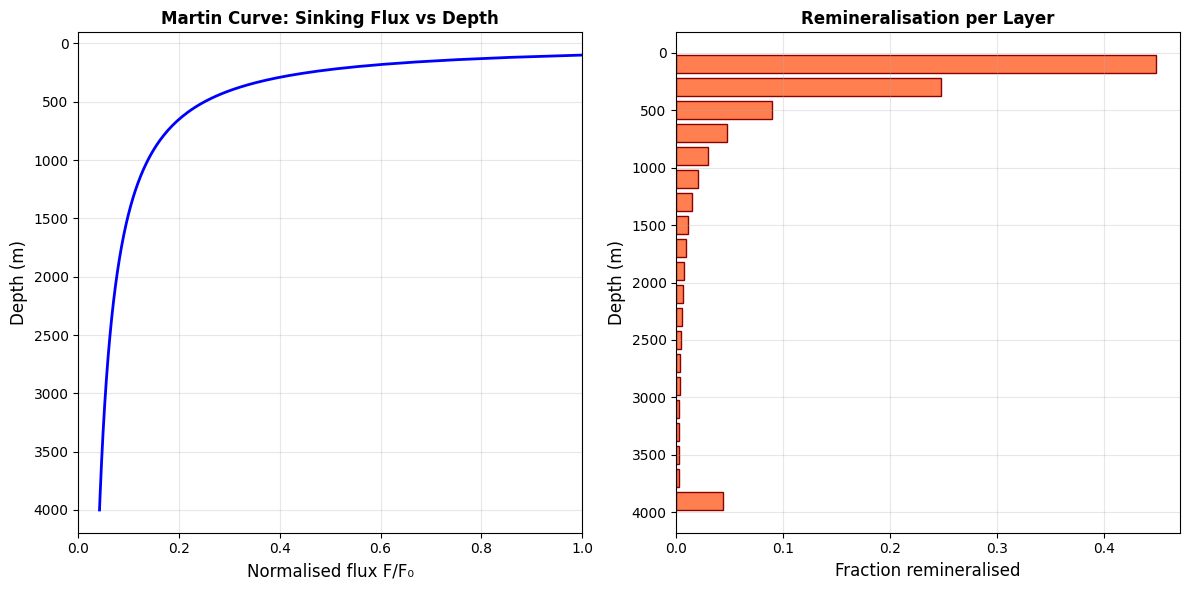

Total remineralised: 1.0000 (should be 1.0)
Fraction above 1000 m: 0.862
Fraction below 1000 m: 0.138


In [3]:
# ============================================================
# Martin curve: remineralisation profile
# ============================================================
def martin_remin_fractions(z_mid, z_edge, z0=100.0, b=0.86):
    """Compute the fraction of export production remineralised
    in each layer, using the Martin power law.
    
    F(z) = (z/z0)^{-b} gives the flux at depth z.
    The remineralisation in a layer is the flux in minus flux out.
    """
    n = len(z_mid)
    fracs = np.zeros(n)
    for k in range(n):
        z_top = max(z_edge[k], z0)    # Martin curve starts at z0
        z_bot = max(z_edge[k+1], z0)
        if z_edge[k+1] <= z0:
            fracs[k] = 0.0  # above euphotic zone, no remin
        else:
            flux_top = (z_top / z0) ** (-b)
            flux_bot = (z_bot / z0) ** (-b)
            fracs[k] = flux_top - flux_bot
    
    # Anything remaining at the bottom is remineralised in the last layer
    flux_bottom = (z_edge[-1] / z0) ** (-b)
    fracs[-1] += flux_bottom
    
    return fracs

remin_frac = martin_remin_fractions(z_mid, z_edge)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Martin curve (continuous)
z_cont = np.linspace(100, 4000, 200)
flux_cont = (z_cont / 100) ** (-b_martin)
ax1.plot(flux_cont, z_cont, 'b-', linewidth=2)
ax1.set_xlabel('Normalised flux F/F₀', fontsize=12)
ax1.set_ylabel('Depth (m)', fontsize=12)
ax1.set_title('Martin Curve: Sinking Flux vs Depth', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)

# Remineralisation fraction per layer
ax2.barh(z_mid, remin_frac, height=dz*0.8, color='coral', edgecolor='darkred')
ax2.set_xlabel('Fraction remineralised', fontsize=12)
ax2.set_ylabel('Depth (m)', fontsize=12)
ax2.set_title('Remineralisation per Layer', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total remineralised: {np.sum(remin_frac):.4f} (should be 1.0)")
print(f"Fraction above 1000 m: {np.sum(remin_frac[z_mid < 1000]):.3f}")
print(f"Fraction below 1000 m: {np.sum(remin_frac[z_mid >= 1000]):.3f}")

In [4]:
# ============================================================
# State vector and RHS
# ============================================================
# State: [PO4_0, ..., PO4_{N-1}, DIC_0, ..., DIC_{N-1}, O2_0, ..., O2_{N-1}]
# Total: 3N variables

N_species = 3
N_total = N_species * N_layers

def unpack(y):
    """Unpack state vector into species arrays."""
    PO4 = y[0:N_layers]
    DIC = y[N_layers:2*N_layers]
    O2  = y[2*N_layers:3*N_layers]
    return PO4, DIC, O2

def pack(PO4, DIC, O2):
    """Pack species arrays into state vector."""
    return np.concatenate([PO4, DIC, O2])


def compute_rhs(y):
    """Right-hand side: diffusion + biology + air-sea exchange.
    
    All concentrations in μmol/kg; time in seconds.
    """
    PO4, DIC, O2 = unpack(y)
    dPO4 = np.zeros(N_layers)
    dDIC = np.zeros(N_layers)
    dO2  = np.zeros(N_layers)
    
    # === 1. Vertical diffusion (all species) ===
    for species, d_arr in [(PO4, dPO4), (DIC, dDIC), (O2, dO2)]:
        for k in range(N_layers):
            if k > 0:
                d_arr[k] += diff * (species[k-1] - species[k])
            if k < N_layers - 1:
                d_arr[k] += diff * (species[k+1] - species[k])
            # No-flux at top (k=0) and bottom (k=N-1) is automatic
    
    # === 2. Biological pump ===
    # Surface production (layer 0): Michaelis-Menten nutrient limitation
    production_P = max(PO4[0], 0.0) / (max(PO4[0], 0.0) + PO4_half) / tau_bio
    export_P = production_P * dz  # export flux in μmol P / (kg·m) × m
    # (We work per unit mass, so export is just production × layer thickness
    #  divided by layer thickness = production. The remin fractions distribute it.)
    
    # Remove nutrients from surface
    dPO4[0] -= production_P
    dDIC[0] -= production_P * R_CP
    dO2[0]  -= production_P * R_OP  # R_OP is negative, so this adds O₂
    
    # Remineralise at depth (distribute production according to Martin curve)
    for k in range(N_layers):
        if remin_frac[k] > 0:
            dPO4[k] += production_P * remin_frac[k]
            dDIC[k] += production_P * remin_frac[k] * R_CP
            dO2[k]  += production_P * remin_frac[k] * R_OP
    
    # === 3. Air-sea gas exchange (surface layer only) ===
    # O₂: restore towards saturation
    dO2[0] += (O2_sat - O2[0]) / tau_gas
    
    # CO₂: simplified — restore DIC towards a value consistent with pCO2_atm
    # (A full treatment would use Ch.5 carbonate chemistry;
    #  here we use a linear approximation for clarity.)
    DIC_eq = 2100.0  # μmol/kg — equilibrium DIC for 280 μatm
    dDIC[0] += (DIC_eq - DIC[0]) / tau_gas
    
    return pack(dPO4, dDIC, dO2)

---

## 8.4 Walker's method: Reverse Euler + Newton-Raphson

The system has $3N = 60$ coupled equations. The diffusion makes it stiff (CFL limit ~$3 \times 10^3$ years for forward Euler!), and the biological coupling adds further complexity.

Walker's reverse Euler with Newton-Raphson handles this elegantly. The Jacobian is computed numerically; with 60 state variables it is a 60×60 matrix, but it is sparse (tridiagonal for diffusion + local coupling for biology). Walker noted that Gaussian elimination handles this without difficulty.

In [5]:
def numerical_jacobian(rhs_func, y):
    """Compute Jacobian of rhs by finite differences."""
    n = len(y)
    J = np.zeros((n, n))
    f0 = rhs_func(y)
    for j in range(n):
        dy = np.zeros(n)
        h = max(abs(y[j]) * 1e-7, 1e-12)
        dy[j] = h
        J[:, j] = (rhs_func(y + dy) - f0) / h
    return J


def reverse_euler_newton(y0, dt, n_steps, tol=1e-10, max_newton=15):
    """Walker's reverse Euler with Newton-Raphson.
    
    For the 3N coupled system: PO₄, DIC, O₂ in N depth layers.
    """
    n = len(y0)
    I = np.eye(n)
    y = y0.copy()
    y_history = [y.copy()]
    newton_counts = []
    
    for step in range(n_steps):
        y_k = y.copy()
        
        for k in range(max_newton):
            f_k = compute_rhs(y_k)
            g_k = y_k - y - dt * f_k
            
            if np.max(np.abs(g_k)) < tol:
                newton_counts.append(k + 1)
                break
            
            J_f = numerical_jacobian(compute_rhs, y_k)
            J_g = I - dt * J_f
            delta = np.linalg.solve(J_g, -g_k)
            y_k = y_k + delta
        else:
            newton_counts.append(max_newton)
        
        y = y_k
        y_history.append(y.copy())
    
    return np.array(y_history), newton_counts

In [6]:
# ============================================================
# Initial conditions: uniform ocean
# ============================================================
PO4_init = np.full(N_layers, 2.2)    # μmol/kg (global mean)
DIC_init = np.full(N_layers, 2200.0) # μmol/kg
O2_init  = np.full(N_layers, 200.0)  # μmol/kg

y0 = pack(PO4_init, DIC_init, O2_init)

# Time step: 10 years (!) — reverse Euler handles this easily
dt_years = 10.0
dt = dt_years * 3.15e7  # seconds
n_steps = 300  # 3000 years total

print(f"Integration: {n_steps} steps × {dt_years} yr = {n_steps*dt_years:.0f} years")
print(f"(Forward Euler CFL limit: ~{dz**2/(2*Kv)/3.15e7:.0f} yr)")
print(f"State vector: {N_total} variables ({N_species} species × {N_layers} layers)")
print(f"\nRunning reverse Euler + Newton-Raphson...")

y_hist, newton_counts = reverse_euler_newton(y0, dt, n_steps)

print(f"Done. Newton iterations: min={min(newton_counts)}, "
      f"max={max(newton_counts)}, mean={np.mean(newton_counts):.1f}")

Integration: 300 steps × 10.0 yr = 3000 years
(Forward Euler CFL limit: ~6 yr)
State vector: 60 variables (3 species × 20 layers)

Running reverse Euler + Newton-Raphson...
Done. Newton iterations: min=3, max=5, mean=3.2


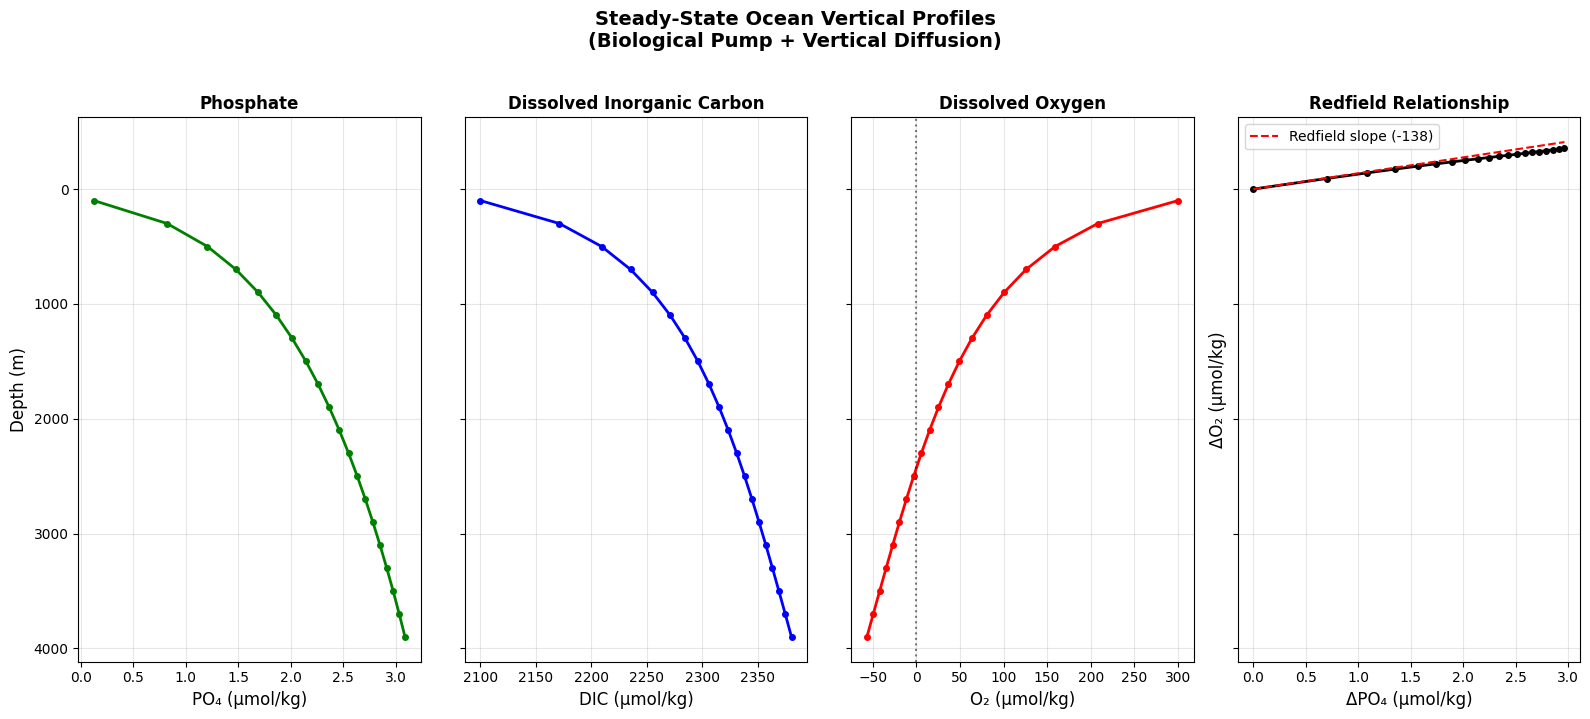

Surface: PO₄=0.12, DIC=2100, O₂=300
Deep:    PO₄=3.09, DIC=2380, O₂=-57
Surface-deep ΔPO₄: 2.97 μmol/kg
Surface-deep ΔO₂:  -357 μmol/kg
Implied O₂:PO₄ ratio: -120 (Redfield: -138)


In [7]:
# ============================================================
# Visualise the steady-state vertical profiles
# ============================================================
y_final = y_hist[-1]
PO4_f, DIC_f, O2_f = unpack(y_final)

fig, axes = plt.subplots(1, 4, figsize=(16, 7), sharey=True)

# PO₄
ax = axes[0]
ax.plot(PO4_f, z_mid, 'g-o', linewidth=2, markersize=4)
ax.set_xlabel('PO₄ (μmol/kg)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.set_title('Phosphate', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# DIC
ax = axes[1]
ax.plot(DIC_f, z_mid, 'b-o', linewidth=2, markersize=4)
ax.set_xlabel('DIC (μmol/kg)', fontsize=12)
ax.set_title('Dissolved Inorganic Carbon', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# O₂
ax = axes[2]
ax.plot(O2_f, z_mid, 'r-o', linewidth=2, markersize=4)
ax.axvline(x=0, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('O₂ (μmol/kg)', fontsize=12)
ax.set_title('Dissolved Oxygen', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Redfield check: ΔO₂ vs ΔPO₄
ax = axes[3]
dPO4 = PO4_f - PO4_f[0]
dO2 = O2_f - O2_f[0]
ax.plot(dPO4, dO2, 'ko-', linewidth=2, markersize=4)
# Expected slope: R_OP = -138
po4_line = np.linspace(0, max(dPO4), 50)
ax.plot(po4_line, R_OP * po4_line, 'r--', linewidth=1.5,
        label=f'Redfield slope ({R_OP:.0f})')
ax.set_xlabel('ΔPO₄ (μmol/kg)', fontsize=12)
ax.set_ylabel('ΔO₂ (μmol/kg)', fontsize=12)
ax.set_title('Redfield Relationship', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

fig.suptitle('Steady-State Ocean Vertical Profiles\n'
             '(Biological Pump + Vertical Diffusion)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Surface: PO₄={PO4_f[0]:.2f}, DIC={DIC_f[0]:.0f}, O₂={O2_f[0]:.0f}")
print(f"Deep:    PO₄={PO4_f[-1]:.2f}, DIC={DIC_f[-1]:.0f}, O₂={O2_f[-1]:.0f}")
print(f"Surface-deep ΔPO₄: {PO4_f[-1]-PO4_f[0]:.2f} μmol/kg")
print(f"Surface-deep ΔO₂:  {O2_f[-1]-O2_f[0]:.0f} μmol/kg")
print(f"Implied O₂:PO₄ ratio: {(O2_f[-1]-O2_f[0])/(PO4_f[-1]-PO4_f[0]):.0f} "
      f"(Redfield: {R_OP:.0f})")

### Physical interpretation

The steady-state profiles should show the classic ocean structure:

- **PO₄**: low at surface (consumed by biology), high at depth (remineralised)
- **DIC**: similar pattern, coupled to PO₄ by Redfield ratio
- **O₂**: high at surface (saturated by atmosphere), decreasing at depth (consumed by remineralisation) — may show an **oxygen minimum zone**

The ΔO₂ vs ΔPO₄ plot should follow the Redfield slope of −138, confirming that the biological pump preserves stoichiometry.

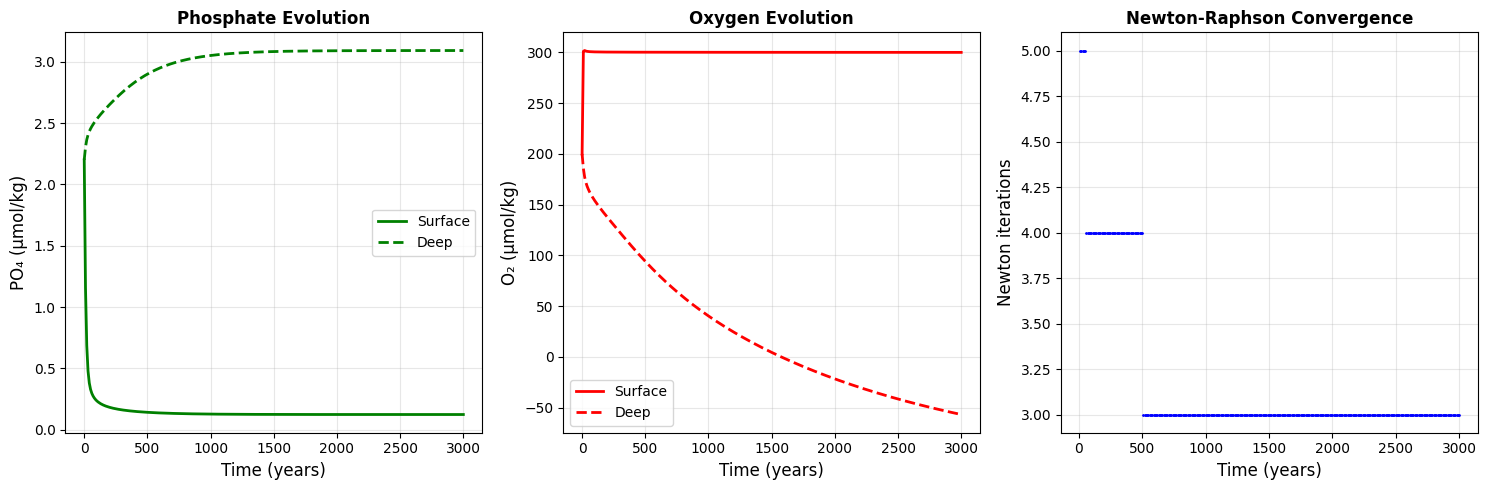

In [8]:
# ============================================================
# Time evolution of approach to steady state
# ============================================================
t_years = np.arange(0, (n_steps + 1) * dt_years, dt_years)

# Extract surface and deep time series
PO4_surf = np.array([unpack(y)[0][0] for y in y_hist])
PO4_deep = np.array([unpack(y)[0][-1] for y in y_hist])
O2_surf  = np.array([unpack(y)[2][0] for y in y_hist])
O2_deep  = np.array([unpack(y)[2][-1] for y in y_hist])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(t_years, PO4_surf, 'g-', linewidth=2, label='Surface')
ax1.plot(t_years, PO4_deep, 'g--', linewidth=2, label='Deep')
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('PO₄ (μmol/kg)', fontsize=12)
ax1.set_title('Phosphate Evolution', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(t_years, O2_surf, 'r-', linewidth=2, label='Surface')
ax2.plot(t_years, O2_deep, 'r--', linewidth=2, label='Deep')
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('O₂ (μmol/kg)', fontsize=12)
ax2.set_title('Oxygen Evolution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

ax3.plot(t_years[1:], newton_counts, 'b.', markersize=2)
ax3.set_xlabel('Time (years)', fontsize=12)
ax3.set_ylabel('Newton iterations', fontsize=12)
ax3.set_title('Newton-Raphson Convergence', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 8.5 Experiment 1: Strength of the biological pump

What happens if the biological pump is stronger or weaker? We vary the biological timescale $\tau_{\text{bio}}$ and observe the effect on vertical gradients.

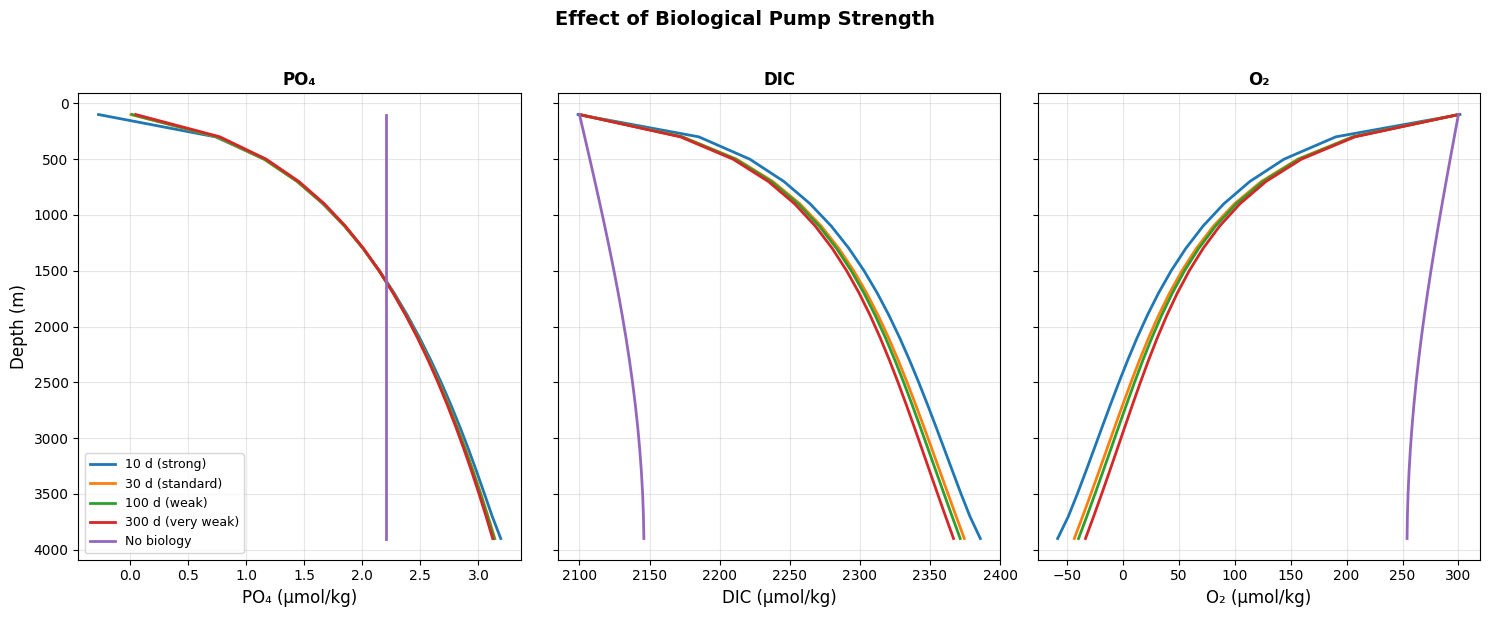

In [9]:
tau_bio_values = [10*86400, 30*86400, 100*86400, 300*86400, 1e20]
tau_labels = ['10 d (strong)', '30 d (standard)', '100 d (weak)',
              '300 d (very weak)', 'No biology']
tau_bio_orig = tau_bio

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for tau_val, lab in zip(tau_bio_values, tau_labels):
    tau_bio = tau_val
    y_test, _ = reverse_euler_newton(y0, dt, 200, tol=1e-8)
    PO4_t, DIC_t, O2_t = unpack(y_test[-1])
    
    axes[0].plot(PO4_t, z_mid, linewidth=2, label=lab)
    axes[1].plot(DIC_t, z_mid, linewidth=2, label=lab)
    axes[2].plot(O2_t, z_mid, linewidth=2, label=lab)

tau_bio = tau_bio_orig  # restore

titles = ['PO₄ (μmol/kg)', 'DIC (μmol/kg)', 'O₂ (μmol/kg)']
for ax, title in zip(axes, titles):
    ax.set_xlabel(title, fontsize=12)
    ax.set_title(title.split('(')[0].strip(), fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()

axes[0].set_ylabel('Depth (m)', fontsize=12)
axes[0].legend(fontsize=9, loc='lower left')
fig.suptitle('Effect of Biological Pump Strength',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Strong pump** → large surface-to-deep gradients: nutrients depleted at the surface, O₂ consumed at depth. In extreme cases, the deep ocean can become **anoxic** (O₂ → 0).

**No pump** → uniform profiles (only diffusion, no biological forcing).

This experiment directly connects to palaeoceanography: changes in the biological pump (through nutrient supply, productivity, or remineralisation depth) control whether the deep ocean is oxic or anoxic — critical for understanding ocean anoxic events (OAEs) and the Great Oxidation Event.

---

## 8.6 Experiment 2: Remineralisation depth

The Martin curve exponent $b$ controls *where* organic matter is remineralised. Small $b$ means particles sink deeper before decomposing (more efficient export to depth). We scan $b$ from 0.4 to 1.5.

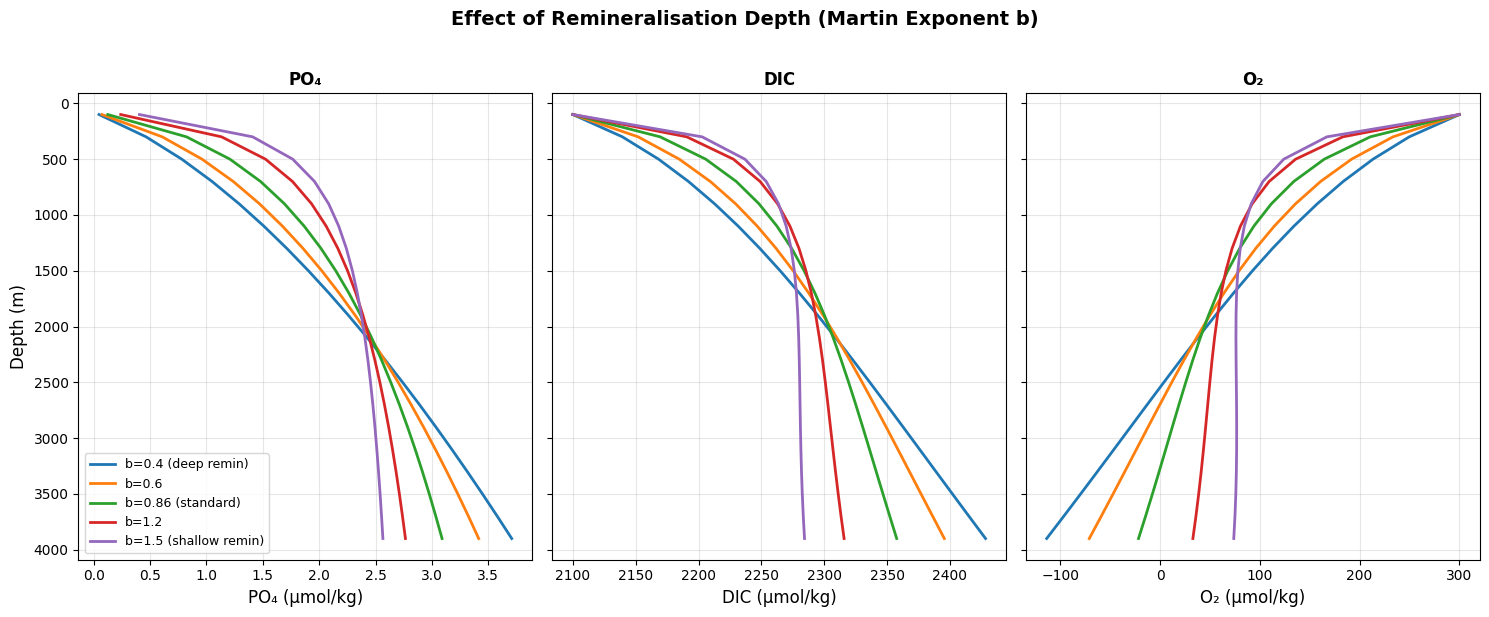

In [10]:
b_values = [0.4, 0.6, 0.86, 1.2, 1.5]
b_labels = ['b=0.4 (deep remin)', 'b=0.6', 'b=0.86 (standard)',
            'b=1.2', 'b=1.5 (shallow remin)']

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for b_val, lab in zip(b_values, b_labels):
    # Recompute Martin fractions
    remin_frac_test = martin_remin_fractions(z_mid, z_edge, b=b_val)
    
    # Temporarily override global remin_frac
    remin_frac_save = remin_frac.copy()
    remin_frac[:] = remin_frac_test
    
    y_test, _ = reverse_euler_newton(y0, dt, 200, tol=1e-8)
    PO4_t, DIC_t, O2_t = unpack(y_test[-1])
    
    remin_frac[:] = remin_frac_save  # restore
    
    axes[0].plot(PO4_t, z_mid, linewidth=2, label=lab)
    axes[1].plot(DIC_t, z_mid, linewidth=2, label=lab)
    axes[2].plot(O2_t, z_mid, linewidth=2, label=lab)

titles = ['PO₄ (μmol/kg)', 'DIC (μmol/kg)', 'O₂ (μmol/kg)']
for ax, title in zip(axes, titles):
    ax.set_xlabel(title, fontsize=12)
    ax.set_title(title.split('(')[0].strip(), fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()

axes[0].set_ylabel('Depth (m)', fontsize=12)
axes[0].legend(fontsize=9, loc='lower left')
fig.suptitle('Effect of Remineralisation Depth (Martin Exponent b)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Deep remineralisation** ($b$ small) → nutrients and CO₂ are sequestered in the deep ocean more effectively. This lowers atmospheric CO₂ and is one mechanism invoked for glacial CO₂ drawdown.

**Shallow remineralisation** ($b$ large) → nutrients are recycled near the surface, weakening the vertical gradient and the biological pump's effect on atmospheric CO₂.

---

## 8.7 Conservation check

The biological pump redistributes species vertically but does not create or destroy them (internal cycling). The only sources/sinks are air-sea exchange. Total ocean inventory should change only through surface exchange.

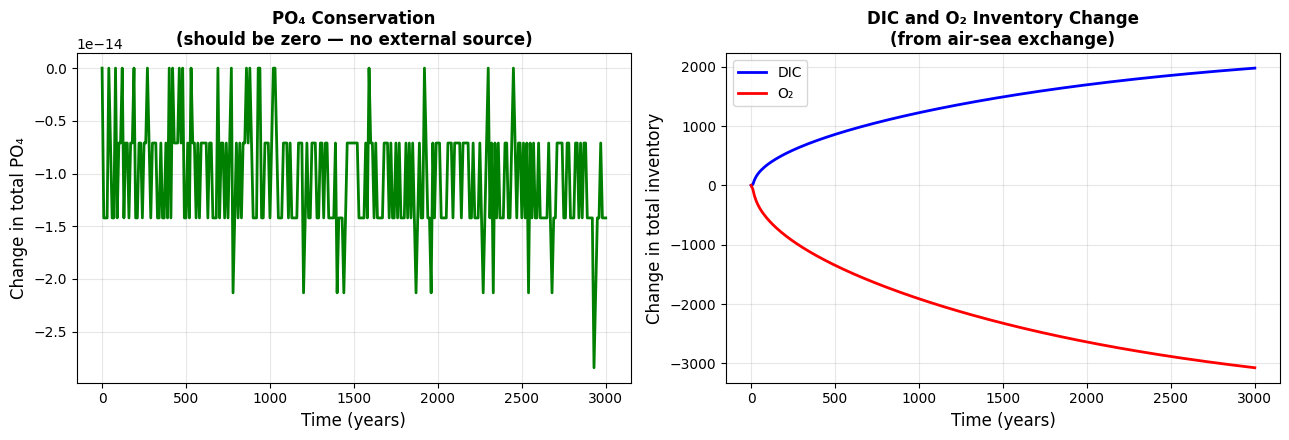

PO₄ conservation error: 2.84e-14 μmol/kg


In [11]:
# Check conservation: total PO₄ should be constant (no external source)
total_PO4 = np.array([np.sum(unpack(y)[0]) for y in y_hist])
total_DIC = np.array([np.sum(unpack(y)[1]) for y in y_hist])
total_O2  = np.array([np.sum(unpack(y)[2]) for y in y_hist])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

# PO₄ should be strictly conserved (no air-sea exchange)
ax1.plot(t_years, total_PO4 - total_PO4[0], 'g-', linewidth=2)
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Change in total PO₄', fontsize=12)
ax1.set_title('PO₄ Conservation\n(should be zero — no external source)',
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# DIC and O₂ change through air-sea exchange
ax2.plot(t_years, total_DIC - total_DIC[0], 'b-', linewidth=2, label='DIC')
ax2.plot(t_years, total_O2 - total_O2[0], 'r-', linewidth=2, label='O₂')
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Change in total inventory', fontsize=12)
ax2.set_title('DIC and O₂ Inventory Change\n(from air-sea exchange)',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PO₄ conservation error: {np.max(np.abs(total_PO4 - total_PO4[0])):.2e} μmol/kg")

---

## 8.8 Experiment 3: Ocean deoxygenation under warming

A warming ocean holds less dissolved O₂ (reduced solubility) and may also have a stronger biological pump (more stratification = less nutrient supply, but also less vertical mixing). We simulate reduced O₂ saturation and reduced mixing.

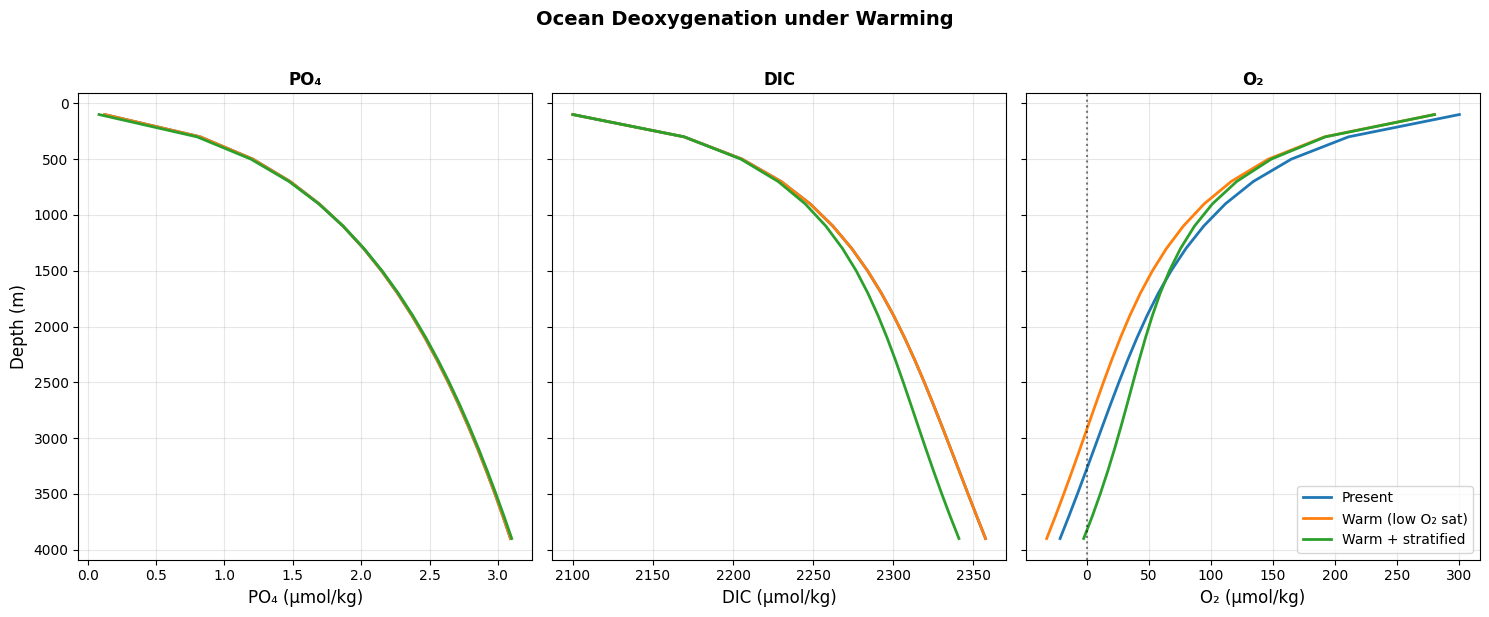

In [12]:
# Deoxygenation experiment
# Scenario: O₂ saturation drops 20 μmol/kg; Kv reduced by 30%

# Save originals
O2_sat_orig = O2_sat
diff_orig = diff

scenarios = [
    ('Present', 300.0, Kv),
    ('Warm (low O₂ sat)', 280.0, Kv),
    ('Warm + stratified', 280.0, Kv * 0.7),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for label, O2_sat_val, Kv_val in scenarios:
    O2_sat = O2_sat_val
    diff = Kv_val / dz**2
    
    y_test, _ = reverse_euler_newton(y0, dt, 200, tol=1e-8)
    PO4_t, DIC_t, O2_t = unpack(y_test[-1])
    
    axes[0].plot(PO4_t, z_mid, linewidth=2, label=label)
    axes[1].plot(DIC_t, z_mid, linewidth=2, label=label)
    axes[2].plot(O2_t, z_mid, linewidth=2, label=label)

# Restore
O2_sat = O2_sat_orig
diff = diff_orig

axes[2].axvline(x=0, color='k', linestyle=':', alpha=0.5)
titles = ['PO₄ (μmol/kg)', 'DIC (μmol/kg)', 'O₂ (μmol/kg)']
for ax, title in zip(axes, titles):
    ax.set_xlabel(title, fontsize=12)
    ax.set_title(title.split('(')[0].strip(), fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()

axes[0].set_ylabel('Depth (m)', fontsize=12)
axes[2].legend(fontsize=10)
fig.suptitle('Ocean Deoxygenation under Warming',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Reduced O₂ solubility** lowers the surface O₂ source, reducing deep ocean O₂. **Increased stratification** (reduced Kv) further isolates the deep ocean from the surface O₂ supply, potentially expanding oxygen minimum zones — a major concern under climate change.

---

## 8.9 Connecting the chapters

This final model brings together all the methods and ideas from the book:

| Element | Source Chapter |
|:---|:---|
| Forward/reverse Euler time stepping | Ch. 2 |
| Multiple reservoirs + Gaussian elimination | Ch. 3 |
| Newton-Raphson for nonlinear systems | Ch. 4 |
| Carbonate chemistry procedures | Ch. 5 |
| Isotope ratio tracking | Ch. 6 |
| Chain of identical reservoirs (diffusion) | Ch. 7 |
| Coupled interacting species | **Ch. 8** |
| Bonus chapter, modern solvers | Ch. 9 |

Walker's whole pedagogical idea: start with the simplest possible model (one reservoir, one species, forward Euler), and build up piece by piece until you have a full ocean biogeochemical model, where we understan every line of code because we built every tool ourself. In the table you also see that there is a Chapter 9, which is not in Walker's book. Here we compare Walker's clear but *primitive* methods with modern (e.g. `SciPy`) solvers.

---

## 8.10 Exercises

**Exercise 8.1:** Add δ¹³C as a fourth interacting species (Chapter 6). Use the isotope ratio equation to track how the biological pump creates a surface-to-deep ¹³C gradient (surface enriched, deep depleted — because photosynthesis preferentially takes ¹²C).

**Exercise 8.2:** Replace the linearised air-sea CO₂ exchange with the full carbonate chemistry from Chapter 5. Compute pCO₂ from DIC and alkalinity in the surface box, and let the air-sea flux depend on the pCO₂ difference. Add alkalinity as a fifth species.

**Exercise 8.3:** Add a second horizontal region ("Atlantic" and "Pacific") connected by thermohaline circulation: deep water forms in the Atlantic (surface → deep) and upwells in the Pacific (deep → surface). Show that the Pacific deep water is older (more remineralised,lower O₂, higher nutrients) than the Atlantic.

**Exercise 8.4:** Explore the "phosphate-oxygen feedback": under anoxic conditions, phosphorus is released from sediments (enhanced recycling). Add a redox-dependent P burial term and show that this creates a positive feedback — more anoxia → more P → more productivity → more anoxia.

**Exercise 8.5:** Connect to the climate model from Chapter 7. Let the ocean temperature profile (from the EBM) control both the O₂ solubility and the vertical diffusivity. Increase CO₂ (which warms the climate via Chapter 7) and show the resulting ocean deoxygenation — a fully coupled climate-biogeochemistry model built entirely from Walker's elementary methods.

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*.  Oxford University Press. Chapter 8: "Interacting Species in identical Reservoirs."
- Redfield, A.C. (1958). The biological control of chemical factors in the environment. *Am. Sci.*, 46, 205–221.
- Martin, J.H., Knauer, G.A., Karl, D.M., and Broenkow, W.W. (1987). VERTEX: carbon cycling in the northeast Pacific. *Deep-Sea Res.*, 34, 267–285.
- Broecker, W.S. and Peng, T.-H. (1982). *Tracers in the Sea*. Eldigio Press, Palisades, New York.
- Sarmiento, J.L. and Gruber, N. (2006). *Ocean Biogeochemical Dynamics*. Princeton University Press.